In [33]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch as ch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Gumbel
import math
import numpy as np
import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import os
import config

from delphi import train
from delphi.utils import model_utils
from delphi import grad
from delphi import oracle
from delphi.utils.datasets import CIFAR, ImageNet
import delphi.utils.constants as consts
import delphi.utils.data_augmentation as da
from delphi.utils.helpers import setup_store_with_metadata
import pickle
import pandas as pd

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# noise distributions
gumbel = Gumbel(0, 1)
num_classes = 10

# file path constants
BASE_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/base_calibrated_'
BASE_CLASSIFIER_PATH = BASE_CLASSIFIER + '/e4476e64-c5bb-4d8a-b2bc-299aed256e88/checkpoint.pt.latest'
LOGIT_BALL_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/trunc_ce_step_lr_50epochs'
STANDARD_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/standard_step_lr_50epochs'
DATA_PATH = '/home/pstefanou/data/'
TRUNC_TRAIN_DATASET = 'trunc_train_calibrated_logit__'
TRUNC_VAL_DATASET = 'trunc_val_calibrated_logit__'
TRUNC_TEST_DATASET = 'trunc_test_calibrated_logit__'

# helper dataset
class TruncatedCIFAR(Dataset):
    """
    Truncated CIFAR-10 dataset [Kri09]_.
    Original dataset has 50k training images and 10k testing images, with the
    following classes:
    * Airplane
    * Automobile
    * Bird
    * Cat
    * Deer
    * Dog
    * Frog
    * Horse
    * Ship
    * Truck
    .. [Kri09] Krizhevsky, A (2009). Learning Multiple Layers of Features
        from Tiny Images. Technical Report.
        
    Truncated dataset only includes images and labels from original dataset that fall within the truncation set.
    """
    def __init__(self, img, label, transform = None):
        """
        """
        self.img = img 
        self.label = label
        self.transform = transform

    def __getitem__(self, idx):
        """
        """
        x = self.img[idx]
        y = self.label[idx]
        # data augmentation
        if self.transform: 
            x = self.transform(x)
            
        return x, y
    
    def __len__(self): 
        return self.img.size(0)
transform_ = transforms.Compose(
    [transforms.ToTensor()])

# hyperparameters
args = Parameters({ 
    'epochs': 25,
    'workers': 8, 
    'batch_size': 128, 
    'lr': 1e-2, 
    'accuracy': True,
    'momentum': 0.0, 
    'weight_decay': 0.0, 
    'save_ckpt_iters': 50,
    'should_save_ckpt': True,
    'log_iters': 1,
    'step_lr': 1, 
    'step_lr_gamma': 1.0,
    'validation_split': .8,
    'shuffle': True,
    'parallel': False, 
    'num_samples': 1000,
    'logit_ball': 7.5,
    'trials': 5,
    'step_lr': 10, 
    'step_lr_gamma': 1.0,
    'temperature': nn.Parameter(ch.ones(1).cuda()),
    'device': 'cuda' if ch.cuda.is_available() else 'cpu'
})


# parameter tuning 
learning_rates = [1e-1, 1e-2, 1e-3]


# Setup and Explore Dataset

In [2]:
ds = CIFAR(data_path='/home/pstefanou/')

In [3]:
import torchvision 
dataset = torchvision.datasets.CIFAR10(root='/home/pstefanou/', train=True,
                                        download=False, transform=transform_)

train_set, val_set = ch.utils.data.random_split(dataset, [45000, 5000])

train_loader = ch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=2)

val_loader = ch.utils.data.DataLoader(val_set, batch_size=128,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='/home/pstefanou/', train=False,
                                       download=False, transform=transform_)
test_loader = ch.utils.data.DataLoader(test_set, batch_size=128,
                                         shuffle=False, num_workers=2)

label: dog


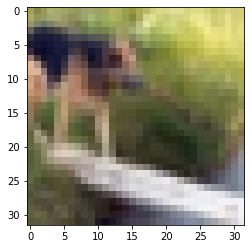

label: automobile


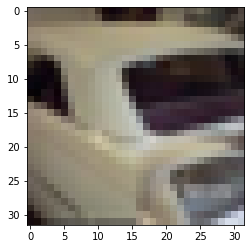

label: deer


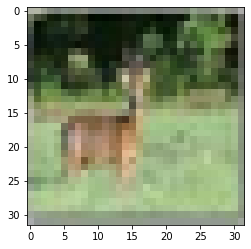

label: ship


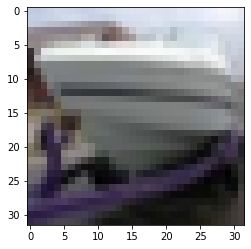

label: airplane


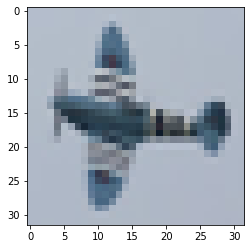

label: truck


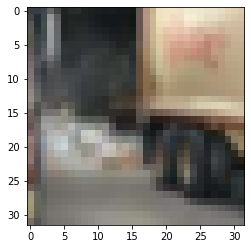

label: bird


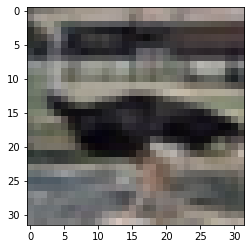

label: frog


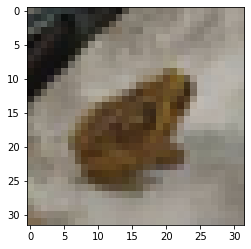

label: cat


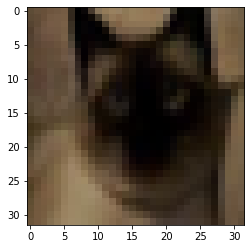

label: horse


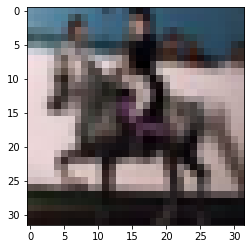

In [4]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(da.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Train Base Classifier

In [5]:
base_classifier, base_sd = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
out_store = store.Store(BASE_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/base_calibrated_/9bf0a4d5-e4d4-466a-890d-0e93a6c27b83


In [216]:
# train
ch.manual_seed(0)
train.train_model(args, base_classifier, (train_loader, val_loader), store=out_store)
out_store.close()

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [218]:
reader = CollectionReader(BASE_CLASSIFIER)
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 17/17 [00:00<00:00, 276.16it/s]

,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,10.120000,2.367606,9.915556,2.361091,22.825660,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe
1,2,33.879997,1.764393,24.013334,2.316112,45.349004,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe
2,3,47.160000,1.448877,41.817780,1.591888,68.033942,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe
3,4,51.180000,1.442712,52.951111,1.296110,90.799535,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe
4,5,63.199997,1.025935,62.111111,1.055269,113.580213,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe


In [219]:
logs = logs[logs['exp_id'] == 'e4476e64-c5bb-4d8a-b2bc-299aed256e88']

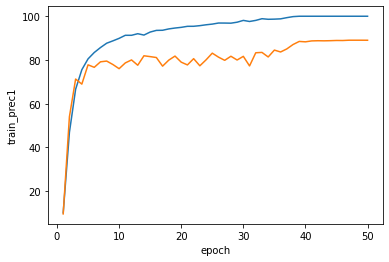

<AxesSubplot:xlabel='epoch', ylabel='train_loss'>

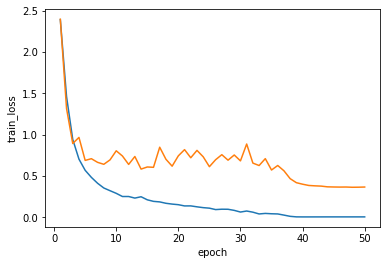

In [220]:
sns.lineplot(data=logs, x='epoch', y='train_prec1')
sns.lineplot(data=logs, x='epoch', y='val_prec1')
plt.show()
sns.lineplot(data=logs, x='epoch', y='train_loss')
sns.lineplot(data=logs, x='epoch', y='val_loss')

# Truncate CIFAR-10

In [6]:
base_classifier = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)[0]

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base_calibrated_/e4476e64-c5bb-4d8a-b2bc-299aed256e88/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base_calibrated_/e4476e64-c5bb-4d8a-b2bc-299aed256e88/checkpoint.pt.latest' (epoch 50)


# Callibrate Base Classifier

In [7]:
from tqdm.notebook import tqdm

def T_scaling(logits, temp):
    return ch.div(logits, temp)

# Use kwargs for calibration method specific parameters
def test(calibration_method=None):
    preds = []
    labels_oneh = []
    correct = 0
    base_classifier.eval()
    with ch.no_grad():
        for data in tqdm(test_loader):
            images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')

            pred = base_classifier(images)[0]

            if calibration_method:
                pred = calibration_method(pred, args.temperature.item())

            # Get softmax values for net input and resulting class predictions
            sm = nn.Softmax(dim=1)
            pred = sm(pred)

            _, predicted_cl = ch.max(pred.data, 1)
            pred = pred.cpu().detach().numpy()

            # Convert labels to one hot encoding
            label_oneh = ch.nn.functional.one_hot(labels, num_classes=num_classes)
            label_oneh = label_oneh.cpu().detach().numpy()

            preds.extend(pred)
            labels_oneh.extend(label_oneh)

            # Count correctly classified samples for accuracy
            correct += sum(predicted_cl == labels).item()

    preds = np.array(preds).flatten()
    labels_oneh = np.array(labels_oneh).flatten()

    correct_perc = correct / len(test_loader.dataset)
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct_perc))
    print(correct_perc)

    return preds, labels_oneh

preds, labels_oneh = test()

def calc_bins(preds):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(preds, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

def get_metrics(preds):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE


import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
    ECE, MCE = get_metrics(preds)
    bins, _, bin_accs, _, _ = calc_bins(preds)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    plt.legend(handles=[ECE_patch, MCE_patch])

    #plt.show()

    plt.savefig('calibrated_network.png', bbox_inches='tight')

#draw_reliability_graph(preds)


  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88 %
0.8823


  0%|          | 0/40 [00:00<?, ?it/s]

Final T_scaling factor: 1.03


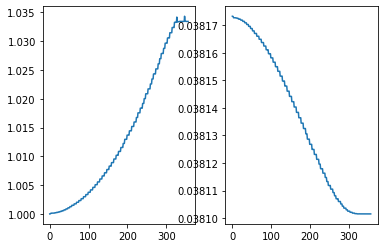

In [8]:
criterion = nn.CrossEntropyLoss()

# Removing strong_wolfe line search results in jump after 50 epochs
optimizer = ch.optim.LBFGS([args.temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []
temps = []
losses = []

for i, data in enumerate(tqdm(val_loader, 0)):
    images, labels = data[0].cuda(), data[1].cuda()

    base_classifier.eval()
    with ch.no_grad():
        logits_list.append(base_classifier(images)[0])
        labels_list.append(labels)

# Create tensors
logits_list = ch.cat(logits_list).cuda()
labels_list = ch.cat(labels_list).cuda()

def _eval():
    loss = criterion(T_scaling(logits_list, args.temperature), labels_list)
    loss.backward()
    temps.append(args.temperature.item())
    losses.append(loss)
    return loss


optimizer.step(_eval)

print('Final T_scaling factor: {:.2f}'.format(args.temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.show()

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88 %
0.8823


  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88 %
0.8823


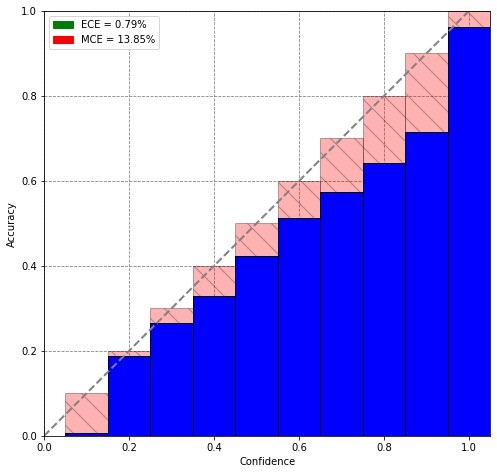

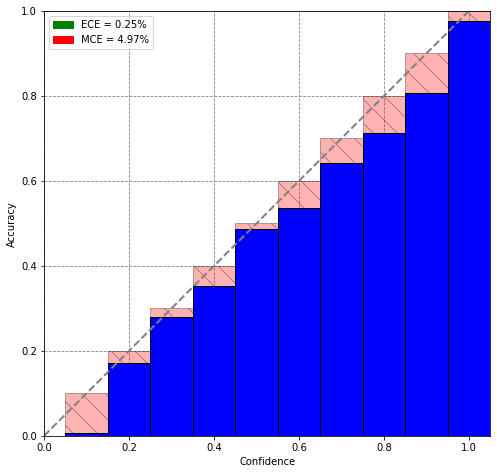

In [225]:
preds_original, _ = test()
preds_calibrated, _ = test(T_scaling)

draw_reliability_graph(preds_original)
draw_reliability_graph(preds_calibrated)

In [226]:
orig_ece, orig_mce = get_metrics(preds_original)
calibrated_ece, calibrated_mce = get_metrics(preds_calibrated)

print("original ece: ", orig_ece)
print("original mce: ", orig_mce)

print("calibrated ece: ", calibrated_ece)
print("calibrated mce: ", calibrated_mce)

original ece:  0.007904780273437498
original mce:  0.13853956139605983
calibrated ece:  0.0025446417236328176
calibrated mce:  0.04965655092497545


In [9]:
# membership oracle
phi = oracle.LogitBallComplement(args.logit_ball)

# check if there exists a cifar 10 train truncated dataset already
if not os.path.isfile(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle'):
    trunc_train_X, trunc_train_y = Tensor([]), Tensor([])
    # unseen test data
    trunc_test_X, trunc_test_y = Tensor([]), Tensor([])
    for inp, targ in train_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        logits = T_scaling(logits, args.temperature.item()).cpu()

        filtered = phi(logits)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_train_X, trunc_train_y = ch.cat([trunc_train_X, inp[indices].cpu()]), ch.cat([trunc_train_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("train alpha: ", trunc_train_X.size(0) / len(train_loader.dataset))
    trunc_train_loader = DataLoader(TruncatedCIFAR(trunc_train_X, trunc_train_y.long(), transform= None), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # train loader
    with open(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_train_loader, f)
else:  
    trunc_train_loader = pd.read_pickle(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle')
trunc_train_loader

In [10]:
# check if there exists a cifar 10 valdation and test truncated dataset
if not os.path.isfile(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle'):
    trunc_val_X, trunc_val_y = Tensor([]), Tensor([]) 

    for inp, targ in val_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        logits = T_scaling(logits, args.temperature.item()).cpu()
        filtered = phi(logits)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_val_X, trunc_val_y = ch.cat([trunc_val_X, inp[indices].cpu()]), ch.cat([trunc_val_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("val alpha: ", trunc_val_X.size(0) / len(val_loader.dataset))
    trunc_val_loader = DataLoader(TruncatedCIFAR(trunc_val_X, trunc_val_y.long(), transform=None), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)
    # truncated test set (unseen data that the model has not been tested on)
    trunc_test_loader = DataLoader(TruncatedCIFAR(trunc_test_X, trunc_test_y.long(), transform=None), 
                             num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # validation loader
    with open(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_val_loader, f)

    # test loader
    with open(DATA_PATH + TRUNC_TEST_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_test_loader, f)
else: 
    trunc_val_loader = pd.read_pickle(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle')
    trunc_test_loader = pd.read_pickle(DATA_PATH + TRUNC_TEST_DATASET + str(args.logit_ball) + '.pickle')
trunc_val_loader, trunc_test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f861edca668>,
 <torch.utils.data.dataloader.DataLoader at 0x7f84700ed2b0>)

In [11]:
print("alpha train: ", len(trunc_train_loader.dataset) / len(train_loader.dataset))
print("alpha val: ", len(trunc_val_loader.dataset) / len(val_loader.dataset))
print("test set size: ", len(trunc_test_loader.dataset))

alpha train:  0.5331777777777778
alpha val:  0.3334
test set size:  24340


# Train Model Using Truncated CE Loss

In [34]:
##### logging store
out_store = store.Store(LOGIT_BALL_CLASSIFIER)
setup_store_with_metadata(args, out_store)
delphi_, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)

Logging in: /home/pstefanou/cifar-10/resnet-18/trunc_ce_step_lr_50epochs/73765c3f-f6fe-42bc-ae4c-be73ada89fe0


# TruncatedCE with Logit Ball Complement Oracle

In [35]:
# train
ch.manual_seed(0)
config.args = args
delphi_ = train.train_model(args, delphi_, (trunc_train_loader, trunc_val_loader), store=out_store, phi=phi, criterion=grad.TruncatedCE.apply)
out_store.close()

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [36]:
reader = CollectionReader(LOGIT_BALL_CLASSIFIER)
metadata = reader.df('metadata')
trunc_logs = reader.df('logs')

reader.close()
trunc_logs

100%|██████████| 1/1 [00:00<00:00, 80.72it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,36.952610,1.728621,26.753637,2.658726,12.960164,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
1,2,38.332333,3.793290,41.874714,1.711447,25.910825,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
2,3,54.289139,5.279710,49.472763,1.645037,38.703408,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
3,4,58.908215,1.763324,54.982704,1.552525,51.473136,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
4,5,71.805634,0.970497,63.168427,1.123327,64.331507,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
5,6,71.505699,1.898208,67.344643,1.039972,77.151843,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
6,7,79.844032,1.234859,73.504776,0.851546,89.947559,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
7,8,74.505096,1.660822,78.001923,0.683158,102.757604,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
8,9,80.323929,0.912781,82.986710,0.545482,115.592725,73765c3f-f6fe-42bc-ae4c-be73ada89fe0
9,10,85.362923,0.663603,86.566917,0.445153,128.328660,73765c3f-f6fe-42bc-ae4c-be73ada89fe0


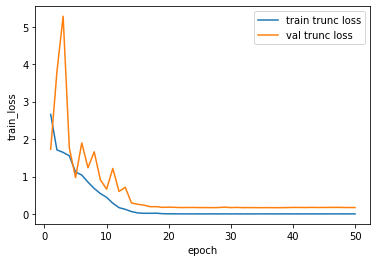

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

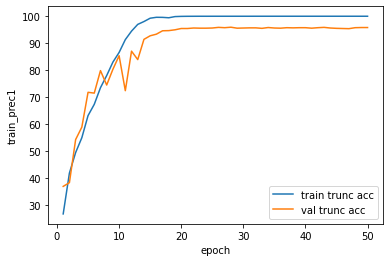

In [37]:
sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='train trunc loss')
sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', label='val trunc loss')
plt.show()

sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='train trunc acc')
sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='val trunc acc')

# Train Model on Standard CE Loss with Truncated Dataset

In [38]:
##### logging store
out_store = store.Store(STANDARD_CLASSIFIER)
setup_store_with_metadata(args, out_store)
standard, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_step_lr_50epochs/8944f932-7278-40c9-96cb-2cf2983419c9


In [39]:
# train
ch.manual_seed(0)
config.args = args
standard_model = train.train_model(args, standard, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [40]:
reader = CollectionReader(STANDARD_CLASSIFIER)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs

100%|██████████| 1/1 [00:00<00:00, 75.57it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,45.590881,1.526674,40.299255,1.683716,12.516003,8944f932-7278-40c9-96cb-2cf2983419c9
1,2,72.705460,0.769827,61.697163,1.054290,25.008404,8944f932-7278-40c9-96cb-2cf2983419c9
2,3,80.563881,0.521347,72.817078,0.756402,37.408093,8944f932-7278-40c9-96cb-2cf2983419c9
3,4,78.104378,0.636168,80.502647,0.540533,49.838872,8944f932-7278-40c9-96cb-2cf2983419c9
4,5,74.325134,0.944316,86.833664,0.370249,62.287851,8944f932-7278-40c9-96cb-2cf2983419c9
5,6,86.082779,0.440787,91.218277,0.242475,74.725360,8944f932-7278-40c9-96cb-2cf2983419c9
6,7,75.044991,0.980243,95.261124,0.140761,87.130649,8944f932-7278-40c9-96cb-2cf2983419c9
7,8,90.041992,0.327841,96.990791,0.086739,99.632607,8944f932-7278-40c9-96cb-2cf2983419c9
8,9,90.101974,0.333994,98.332848,0.050824,112.222662,8944f932-7278-40c9-96cb-2cf2983419c9
9,10,94.121170,0.228995,99.183098,0.027395,124.692114,8944f932-7278-40c9-96cb-2cf2983419c9


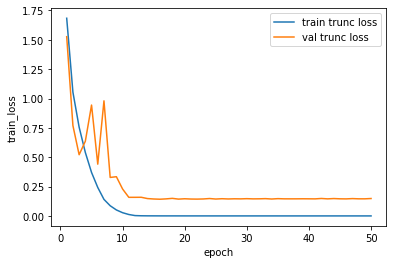

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

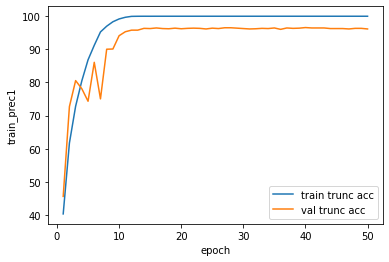

In [41]:
sns.lineplot(data=logs, x='epoch', y='train_loss', label='train trunc loss')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='val trunc loss')
plt.show()

sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train trunc acc')
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val trunc acc')

# Load Trained Models into Notebook

In [42]:
base, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)
delphi_, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=LOGIT_BALL_CLASSIFIER + '/73765c3f-f6fe-42bc-ae4c-be73ada89fe0/checkpoint.pt.latest')
standard_model, _ =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=STANDARD_CLASSIFIER + '/8944f932-7278-40c9-96cb-2cf2983419c9/checkpoint.pt.latest')

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base_calibrated_/e4476e64-c5bb-4d8a-b2bc-299aed256e88/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base_calibrated_/e4476e64-c5bb-4d8a-b2bc-299aed256e88/checkpoint.pt.latest' (epoch 50)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/trunc_ce_step_lr_50epochs/73765c3f-f6fe-42bc-ae4c-be73ada89fe0/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/trunc_ce_step_lr_50epochs/73765c3f-f6fe-42bc-ae4c-be73ada89fe0/checkpoint.pt.latest' (epoch 50)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_step_lr_50epochs/8944f932-7278-40c9-96cb-2cf2983419c9/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_step_lr_50epochs/8944f932-7278-40c9-96cb-2cf2983419c9/checkpoint.pt.latest' (epoch 50)


# Test Accuracy

In [43]:
delphi_store = store.Store(LOGIT_BALL_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/trunc_ce_step_lr_50epochs/c87fbc15-08a2-4267-96c5-33ae7b95fca9


In [44]:
delphi_unseen_results = train.eval_model(args, delphi_, trunc_test_loader, delphi_store)
print("delphi unseen results: ", delphi_unseen_results)

delphi_test_results = train.eval_model(args, delphi_, test_loader, delphi_store)
print("delphi test results: ", delphi_test_results)

delphi_train_results = train.eval_model(args, delphi_, trunc_train_loader, delphi_store)
print("delphi train results: ", delphi_train_results)

delphi_val_results = train.eval_model(args, delphi_, trunc_val_loader, delphi_store)
print("delphi val results: ", delphi_val_results)
delphi_store.close()

  0%|          | 0/191 [00:00<?, ?it/s]

delphi unseen results:  {'test_prec1': tensor(67.7979, device='cuda:0'), 'test_loss': 1.7303702126199727, 'time': 4.064807415008545}


  0%|          | 0/79 [00:00<?, ?it/s]

delphi test results:  {'test_prec1': tensor(75.7000, device='cuda:0'), 'test_loss': 1.2806125955581664, 'time': 1.656463861465454}


  0%|          | 0/188 [00:00<?, ?it/s]

delphi train results:  {'test_prec1': tensor(99.9833, device='cuda:0'), 'test_loss': 0.003076611882174432, 'time': 3.9223904609680176}


  0%|          | 0/14 [00:00<?, ?it/s]

delphi val results:  {'test_prec1': tensor(95.8008, device='cuda:0'), 'test_loss': 0.17259477689051045, 'time': 0.734553337097168}


In [45]:
base_store = store.Store(BASE_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/base_calibrated_/82d2b83f-a31f-449f-ac58-c6b127b72b98


In [46]:
base_unseen_results = train.eval_model(args, base, trunc_test_loader, base_store)
print("base unseen results: ", base_unseen_results)

base_test_results = train.eval_model(args, base, test_loader, base_store)
print("base test results: ", base_test_results)

base_train_results = train.eval_model(args, base, trunc_train_loader, base_store)
print("base train results: ", base_train_results)

base_val_results = train.eval_model(args, base, trunc_val_loader, base_store)
print("base val results: ", base_val_results)
base_store.close()

  0%|          | 0/191 [00:00<?, ?it/s]

base unseen results:  {'test_prec1': tensor(97.7732, device='cuda:0'), 'test_loss': 0.07419560985944265, 'time': 4.054065942764282}


  0%|          | 0/79 [00:00<?, ?it/s]

base test results:  {'test_prec1': tensor(88.2300, device='cuda:0'), 'test_loss': 0.38766819829940796, 'time': 1.66805100440979}


  0%|          | 0/188 [00:00<?, ?it/s]

base train results:  {'test_prec1': tensor(100., device='cuda:0'), 'test_loss': 0.00041348976352267516, 'time': 3.870546340942383}


  0%|          | 0/14 [00:00<?, ?it/s]

base val results:  {'test_prec1': tensor(99.5801, device='cuda:0'), 'test_loss': 0.033390128673861576, 'time': 0.7278604507446289}


In [47]:
standard_store = store.Store(STANDARD_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_step_lr_50epochs/8c328021-98f8-47cc-a58a-267767988323


In [48]:
standard_unseen_results = train.eval_model(args, standard_model, trunc_test_loader, standard_store)
print("standard unseen results: ", standard_unseen_results)

standard_test_results = train.eval_model(args, standard_model, test_loader, standard_store)
print("standard test results: ", standard_test_results)

standard_train_results = train.eval_model(args, standard_model, trunc_train_loader, standard_store)
print("standard train results: ", standard_train_results)

standard_val_results = train.eval_model(args, standard_model, trunc_val_loader, standard_store)
print("standard val results: ", standard_val_results)
standard_store.close()

  0%|          | 0/191 [00:00<?, ?it/s]

standard unseen results:  {'test_prec1': tensor(70.6204, device='cuda:0'), 'test_loss': 1.4577881422215244, 'time': 4.052046060562134}


  0%|          | 0/79 [00:00<?, ?it/s]

standard test results:  {'test_prec1': tensor(77.9600, device='cuda:0'), 'test_loss': 1.0855117395401002, 'time': 1.6756796836853027}


  0%|          | 0/188 [00:00<?, ?it/s]

standard train results:  {'test_prec1': tensor(100., device='cuda:0'), 'test_loss': 2.5264574630418743e-05, 'time': 3.8607800006866455}


  0%|          | 0/14 [00:00<?, ?it/s]

standard val results:  {'test_prec1': tensor(96.1608, device='cuda:0'), 'test_loss': 0.14822543228804774, 'time': 0.7266895771026611}


In [49]:
delphi_store = store.Store(LOGIT_BALL_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/trunc_ce_step_lr_50epochs/e9b23382-a21a-42c6-9982-65488d3b1835


In [50]:
delphi_store.close()

In [51]:
reader = CollectionReader(LOGIT_BALL_CLASSIFIER)

100%|██████████| 3/3 [00:00<00:00, 104.33it/s]


4

In [54]:
ch.randperm(20)

tensor([ 9,  1, 16,  0,  5,  8, 11, 17, 13, 18,  3, 19, 10,  7,  6, 14,  2, 15,
        12,  4])

In [55]:
res = CollectionReader('/home/pstefanou/cifar-10/resnet-18/script_test')

100%|██████████| 4/4 [00:00<00:00, 30.71it/s]


In [56]:
res.df('logs')

,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,51.289742,1.420216,44.496311,1.503395,11.946661,1e6ce69d-43c1-4f94-b5f7-98a824be07bf
0,1,54.649067,1.292472,38.761307,1.674560,12.360491,680e3fbc-142b-4e1c-9e21-a3eb8550b736
0,1,49.670063,1.371793,45.008961,1.497794,12.005665,724ee1f4-9fa0-4595-9510-07ed9e02cbd0
0,1,35.212955,2.010287,38.490395,1.683112,12.319710,7382cc51-c242-41f6-bf18-01aa69b82c5d


In [58]:
res.df('val')

,test_prec1,test_loss,time,exp_id
0,51.289742,1.420216,0.552687,1e6ce69d-43c1-4f94-b5f7-98a824be07bf
0,54.649067,1.292472,0.548156,680e3fbc-142b-4e1c-9e21-a3eb8550b736
0,49.670063,1.371793,0.561502,724ee1f4-9fa0-4595-9510-07ed9e02cbd0
0,35.212955,2.010287,0.539746,7382cc51-c242-41f6-bf18-01aa69b82c5d


In [59]:
res.close()